Here we want to do the Tutorial part 2 on the ALMA logo

In [28]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from astropy.utils.data import download_file


In [10]:
from mpol import coordinates, gridding, losses, precomposed, utils
from mpol.__init__ import zenodo_record
from mpol.precomposed import SimpleNet

In [5]:
# downloading extracted visibilities file
fname = download_file(
    f"https://zenodo.org/record/{zenodo_record}/files/logo_cube.noise.npz",
    cache=True,
    show_progress=True,
    pkgname="mpol",
)

# this is a multi-channel dataset... but for demonstration purposes we'll use
# only the central, single channel
chan = 4
d = np.load(fname)
uu = d["uu"][chan]
vv = d["vv"][chan]
weight = d["weight"][chan]
data = d["data"][chan]
data_re = data.real
data_im = data.imag

In [6]:
# define the image dimensions, making sure they are big enough to fit all
# of the expected emission
coords = coordinates.GridCoords(
    cell_size=0.03, npix=180
)  # Smaller cell size and larger npix value can greatly increase run time
averager = gridding.DataAverager(
    coords=coords, uu=uu, vv=vv, weight=weight, data_re=data_re, data_im=data_im
)

# export to PyTorch dataset
dset = averager.to_pytorch_dataset()

import a mpol.precomposed.SimpleNet model for RML imaging.

In [11]:
model = SimpleNet(coords=coords, nchan=averager.nchan)

In [8]:
# Calculate the dirty image
imager = gridding.DirtyImager(
    coords=coords, uu=uu, vv=vv, weight=weight, data_re=data_re, data_im=data_im)

img, beam = imager.get_dirty_image(weighting="briggs", robust=1.0, unit="Jy/arcsec^2")

<Figure size 640x480 with 0 Axes>

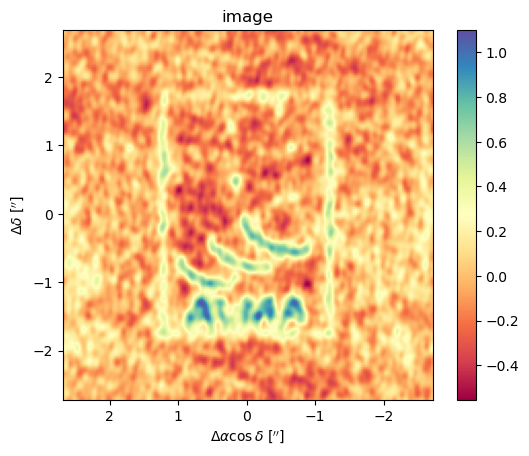

In [9]:
plt.set_cmap(
    "Spectral"
)  # using Matplotlib diverging colormap to accentuate negative values
kw = {"origin": "lower", "extent": imager.coords.img_ext}
fig, ax = plt.subplots(ncols=1)
snp = ax.imshow(np.squeeze(img), **kw)
ax.set_title("image")
ax.set_xlabel(r"$\Delta \alpha \cos \delta$ [${}^{\prime\prime}$]")
ax.set_ylabel(r"$\Delta \delta$ [${}^{\prime\prime}$]")
plt.colorbar(snp)

In [12]:
# convert the dirty image into a tensor
dirty_image = torch.tensor(img.copy())

# initialize an optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.5)
loss_fn = torch.nn.MSELoss()  # creating the MSEloss function from Pytorch

In [13]:
for iteration in range(500):

    optimizer.zero_grad()

    model()  # get the predicted model
    sky_cube = model.icube.sky_cube

    loss = loss_fn(sky_cube, dirty_image)  # calculate the loss

    loss.backward()  # calculate gradients of parameters
    optimizer.step()  # update the parameters

[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


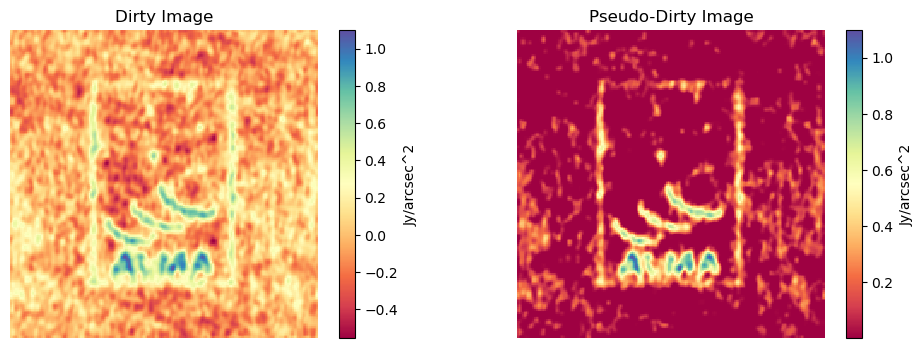

In [24]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 4))

Dirty_image = ax[0].imshow(
    np.squeeze(dirty_image.detach().cpu().numpy()),
    origin="lower",
    interpolation="none",
    extent=model.icube.coords.img_ext,
)
# add a colorbar
plt.colorbar(Dirty_image, ax=ax[0], label="Jy/arcsec^2")

Pseudo_dirty_image=ax[1].imshow(
    np.squeeze(model.icube.sky_cube.detach().cpu().numpy()),
    origin="lower",
    interpolation="none",
    extent=model.icube.coords.img_ext,
)
# add a colorbar and set the size of the colorbar to match the size of the image
plt.colorbar(Pseudo_dirty_image, ax=ax[1], label="Jy/arcsec^2")




r = 0.75
for a in ax:
    # a.set_xlim(left=0.75, right=-0.75)
    # a.set_ylim(bottom=-0.75, top=0.75)
    a.axis("off")

ax[0].set_title("Dirty Image")
_ = ax[1].set_title("Pseudo-Dirty Image")

In [25]:
torch.save(model.state_dict(), "model.pt")

# Visualization utilities

In [29]:

from torch.utils.tensorboard import SummaryWriter
import os

logs_base_dir = "./logs/"
writer = SummaryWriter(logs_base_dir)
os.makedirs(logs_base_dir, exist_ok=True)
%load_ext tensorboard

ModuleNotFoundError: No module named 'tensorboard'